In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline

import sys
sys.path.append('./tree-parser')

import collections
import math
import numpy as np
import random

from matplotlib import pylab
from sklearn.manifold import TSNE

import rntn
import tree as tr

In [2]:
dim = 10
output_dim = 5
batch_size = 30
reg = 1e-6
lr = 1e-1
epochs = 10

# Load or train the model
model_filename = "models/visual_modeld10.pickle"

#model = rntn.RNTN(dim=dim, output_dim=output_dim, batch_size=batch_size, 
#                 reg=reg, learning_rate=lr, max_epochs=epochs)

# Train
train_trees = tr.load_trees('train')
#model.train(train_trees, model_filename=model_filename)

model = rntn.RNTN.load(model_filename)

Reading 'trees/train.txt'...
Model loaded successfully from file models/visual_modeld10.pickle


In [3]:
num_points = 400
embeddings = model.embedding.T

norm = np.sqrt(np.sum(np.square(embeddings), 0, keepdims=True))
normalized_embeddings = embeddings / norm

embedding_slice = normalized_embeddings[1:num_points + 1, :]

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
print(embedding_slice.shape)
two_d_embeddings = tsne.fit_transform(embedding_slice)
print(two_d_embeddings.shape)

(400, 10)
(400, 2)


In [4]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:] # Transformed to 2D
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
        #pylab.rcParams.update({'font.size': 20})
    pylab.show()

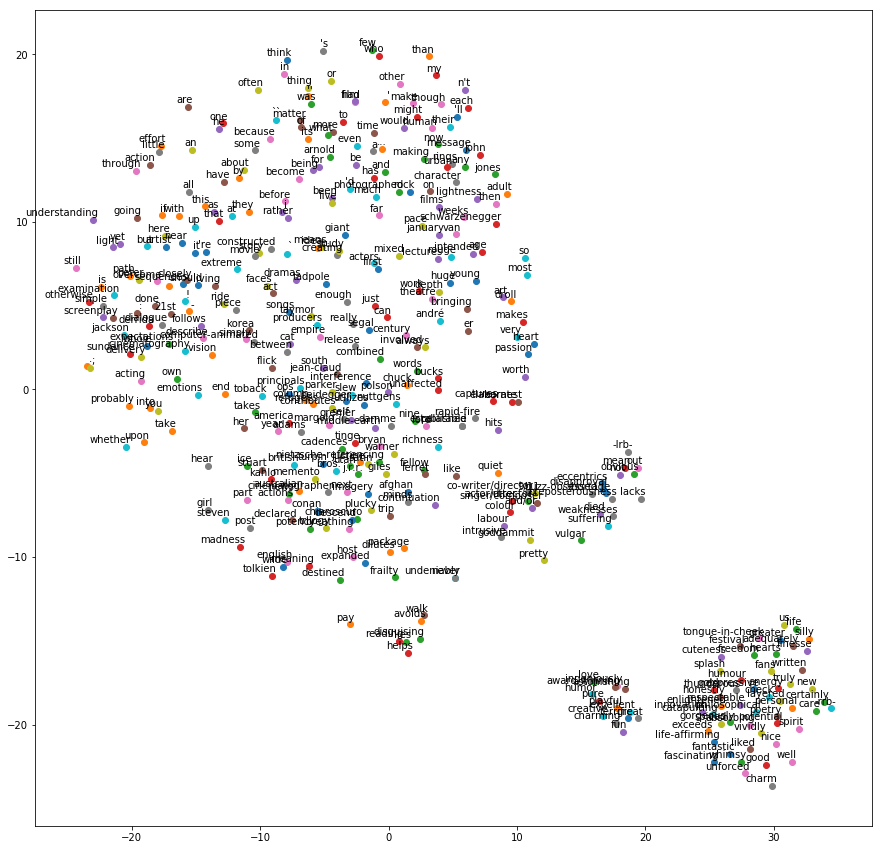

In [5]:
reverse_dictionary = dict(zip(model.dictionary.values(), model.dictionary.keys())) 
words = [reverse_dictionary[i] for i in range(1, num_points + 1)]

plot(two_d_embeddings, words)

In [6]:
# Try to visualize positive and negative words
word_size = 100
positive_words = set()
negative_words = set()
neutral_words = set()

for tree in train_trees:
    for label, leaf in tree.labeled_leaves():
        pos_words_len = len(positive_words)
        neu_words_len = len(neutral_words)
        neg_words_len = len(negative_words)
        
        if label == 4 and pos_words_len < word_size:
            positive_words.add(leaf)
        elif label == 2 and neu_words_len < word_size and leaf.isalpha():
            neutral_words.add(leaf)
        elif label == 0 and neg_words_len < word_size:
            negative_words.add(leaf)
    
    if pos_words_len >= word_size and neu_words_len >= word_size and neg_words_len >= word_size:
        break

print(positive_words)
print()
print(neutral_words)
print()
print(negative_words)

{'honest', 'captivating', 'pretty', 'laughter', 'confident', 'shines', 'cutting-edge', 'laughing', 'beautiful', 'remarkable', 'pleasant', 'thrilling', 'pleasure', 'amusing', 'brilliantly', 'satisfying', 'enjoy', 'humor', 'glorious', 'impeccable', 'masterpiece', 'freedom', 'exquisite', 'grand', 'love', 'funniest', 'ingenious', 'engrossing', 'informative', 'oscar-sweeping', 'dazzling', 'smart', 'oscar-worthy', 'elegant', 'entertaining', 'hilarious', 'poignant', 'great', 'celebrate', 'best', 'charming', 'genuine', 'sweet', 'joy', 'worthy', 'terrific', 'masterfully', 'goodies', 'marvelous', 'fun', 'wiser', 'powerful', 'successful', 'encourage', 'fresh', 'engaging', 'perfect', 'thoughtful', 'clever', 'imaginative', 'playful', 'uplifting', 'sexy', 'enthralling', 'better', 'four-star', 'winner', 'majestic', 'brilliant', 'nicest', 'entertained', 'darling', 'sparkles', 'sensational', 'kids-and-family-oriented', 'excellent', 'happy', 'pure', 'spirited', 'memorable', 'superb', 'exhilarating', 'ho

In [7]:
positive_words_vectors = np.zeros((word_size,dim))
negative_words_vectors = np.zeros((word_size,dim))
neutral_words_vectors = np.zeros((word_size,dim))

for idx, positive_word in enumerate(positive_words):
    if positive_word in model.dictionary:
        positive_words_vectors[idx] = normalized_embeddings[model.dictionary[positive_word], :]
    
for idx, neutral_word in enumerate(neutral_words):
    if neutral_word in model.dictionary:
        neutral_words_vectors[idx] = normalized_embeddings[model.dictionary[neutral_word], :]
    
for idx, negative_word in enumerate(negative_words):
    if negative_word in model.dictionary:
        negative_words_vectors[idx] = normalized_embeddings[model.dictionary[negative_word], :]

pnembed = np.vstack([positive_words_vectors, negative_words_vectors])
pnnembed = np.vstack([positive_words_vectors, neutral_words_vectors, negative_words_vectors])

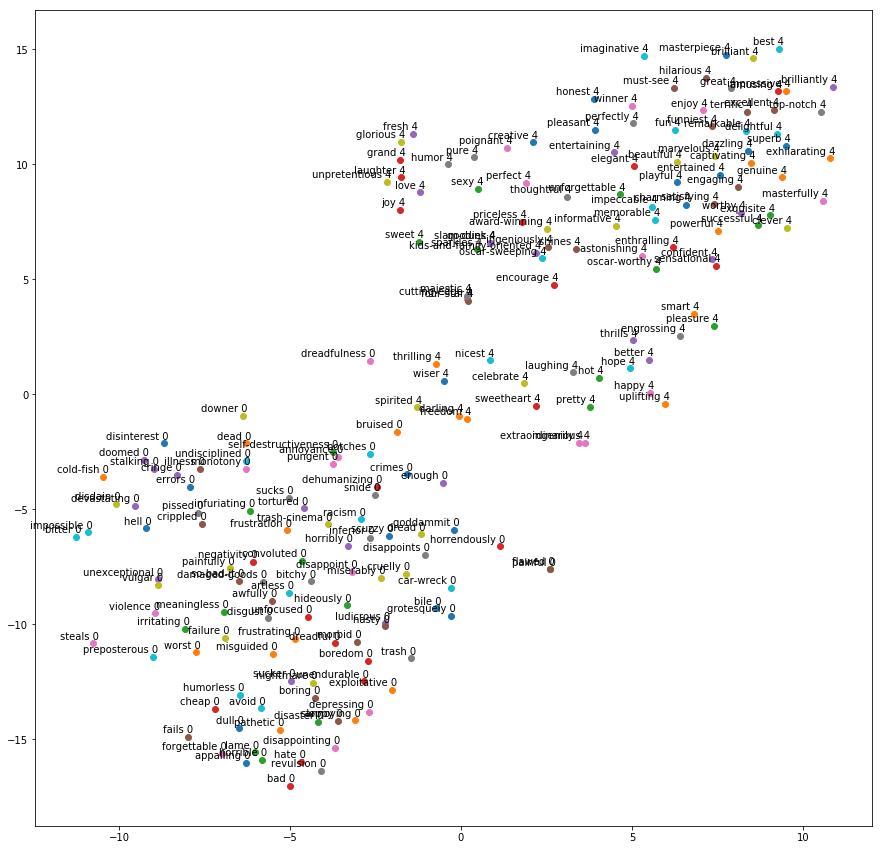

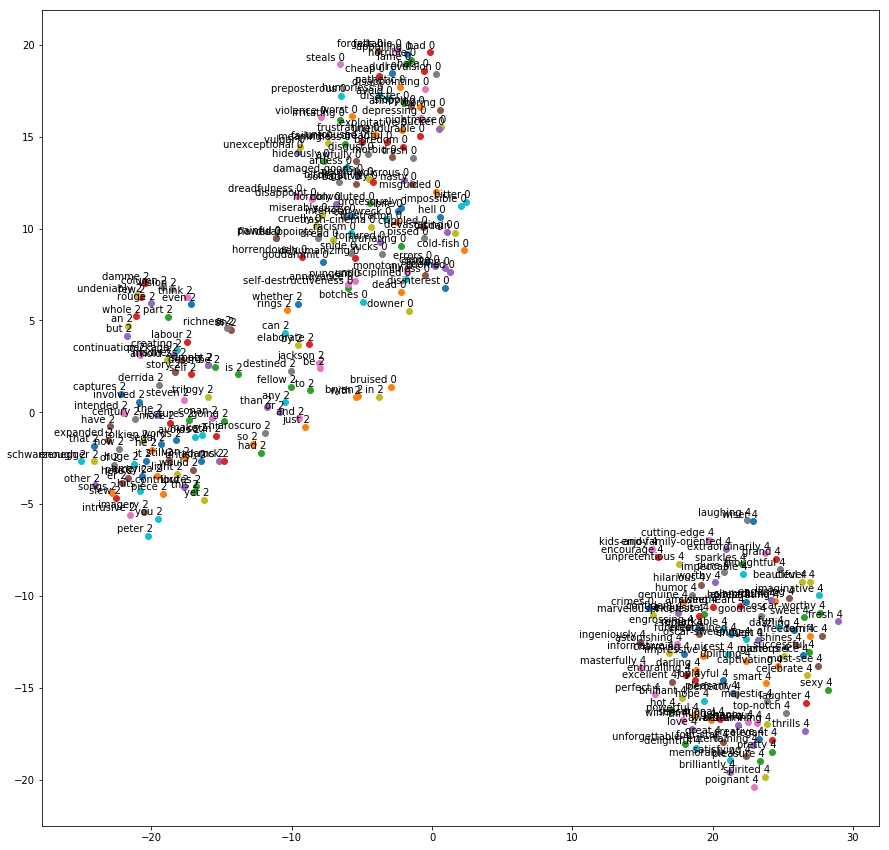

In [8]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=10000, method='exact')

twod_embed_2_classes = tsne.fit_transform(pnembed)
twod_embed_3_classes = tsne.fit_transform(pnnembed)

words_2_classes = []
words_3_classes = []

for pos_word in positive_words:
    words_2_classes.append(pos_word + " 4")
    
for neg_word in negative_words:
    words_2_classes.append(neg_word + " 0")
    
for neu_word in neutral_words:
    words_3_classes.append(neu_word + " 2")
    
words_3_classes.extend(words_2_classes)

plot(twod_embed_2_classes, words_2_classes)
plot(twod_embed_3_classes, words_3_classes)

In [9]:
def closest_to_vector(vector_to_test, embeddings, reverse_dictionary):
    cosine_similarities = []
    # -1 - opposite, 1 - the same
    # cosine similarity = 1 - cosine distance
    for idx, vector in enumerate(embeddings):
        cosine_similarities.append((reverse_dictionary[idx], 1 - spatial.distance.cosine(vector_to_test, vector)))
    cosine_similarities.sort(reverse = True, key=lambda x:x[1])
    return cosine_similarities[1:11]

In [10]:
from scipy import spatial

random_positive_word = random.sample(positive_words, 1)[0]
random_positive_word_vector = embeddings[model.dictionary[random_positive_word], :]
print("The positive word is: %s" % random_positive_word)
print("Vector for the word is: %s" % (random_positive_word_vector))

words = []

print("\nClosest 10 words to this vector are:")
for word, distance in closest_to_vector(random_positive_word_vector, embeddings, reverse_dictionary):
    print("('%s', %.3f)" % (word, distance), end = " ") 

print()
random_negative_word = random.sample(negative_words, 1)[0]
random_negative_word_vector = embeddings[model.dictionary[random_negative_word], :]
print()
print("The negative word is: %s" % random_negative_word)
print("Vector for the word is: %s" % (random_negative_word_vector))

words = []

print("\nClosest 10 words to this vector are:")
for word, distance in closest_to_vector(random_negative_word_vector, embeddings, reverse_dictionary):
    print("('%s', %.3f)" % (word, distance), end = " ") 

The positive word is: worthy
Vector for the word is: [ 0.85595827 -0.28685369  0.7652058  -0.18226756 -0.30650073 -0.10156929
 -0.74763403 -0.68281385  0.77910261  0.14141242]

Closest 10 words to this vector are:
('beautiful', 0.966) ('successful', 0.965) ('topnotch', 0.964) ('terrific', 0.959) ('satisfies', 0.958) ('informative', 0.954) ('amaze', 0.954) ('enthralling', 0.953) ('powerful', 0.951) ('satisfying', 0.951) 

The negative word is: crippled
Vector for the word is: [ 0.41649679 -0.22656108 -0.14974718  0.34550721 -0.05736948 -0.14067435
 -0.51660782 -0.7110394   0.19004213 -0.2831056 ]

Closest 10 words to this vector are:
('convoluted', 0.939) ('pissed', 0.938) ('joyless', 0.921) ('nasty', 0.921) ('choppy', 0.919) ('disgust', 0.917) ('cheap', 0.916) ('unlikable', 0.914) ('frustrating', 0.913) ('tortured', 0.907) 